# Homework Assignment 1
For this assignment, we are given a dataset composed of 2225 real news [http://mlg.ucd.ie/datasets/bbc.html]. Each of these news are labeled as Bussiness (0), Entertainment (1), Politics (2), Sport (3) and Tech (4). The dataset is already preprocessed such that each column indicates the number of occurrences of a given word for a given document instance. We will train a Multinomial Naive Bayes model and a Bernoulli Naive Bayes model to classify the news into their respective categories.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

## 1. Loading and Understanding the Data

In [14]:
x_train = pd.read_csv("X_train.csv",delim_whitespace=True)
x_test = pd.read_csv("X_test.csv", delim_whitespace = True)
y_train = pd.read_csv("y_train.csv", delim_whitespace=True, header = None)
y_test = pd.read_csv("y_test.csv", delim_whitespace=True, header = None)

In [15]:
start_time = datetime.datetime.now()
file = open("X_train.csv", "r")
dictionary = file.readline().split(" ")

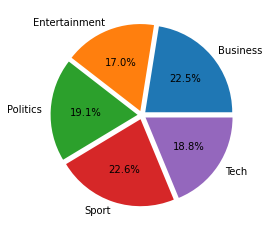

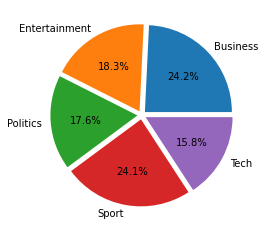

In [16]:
frequencies_train = y_train[0].value_counts().sort_index()
frequencies_test = y_test[0].value_counts().sort_index()
def plot_pie(frequencies):
    class_labels = ["Business", "Entertainment", "Politics", "Sport", "Tech"]
    explodes = [0.05] * 5
    plt.pie(frequencies, labels = class_labels, explode = explodes, autopct ='%1.1f%%')
    plt.show()
plot_pie(frequencies_train)
plot_pie(frequencies_test)

In [17]:
# Prior Probabilities of each class
priors =  frequencies_train / frequencies_train.sum() 
priors

0    0.224820
1    0.170264
2    0.191247
3    0.226019
4    0.187650
Name: 0, dtype: float64

In [18]:
percentages_train = priors.to_numpy()

In [19]:
words = [x_train[y_train[0] == 4]["alien"].value_counts(),
         x_train[y_train[0] == 4]["thunder"].value_counts()]
counts = [0, 0]
for word in range(len(words)):
    for index in range(len(words[word])):
        counts[word] += words[word][index] * index

count_tech = x_train[y_train[0] == 4].sum().sum()
likelihood = np.log(counts / count_tech)
print(f"Number of appearence of 'alien': {counts[0]}")
print(f"Number of appearence of 'thunder': {counts[1]}")
print("-" * 50)
print(f"ln(P(alien| Y= Tech)) = {likelihood[0]}")
print(f"ln(P(alien| Y= Tech)) = {likelihood[1]}")

Number of appearence of 'alien': 3
Number of appearence of 'thunder': 0
--------------------------------------------------
ln(P(alien| Y= Tech)) = -10.171387747476452
ln(P(alien| Y= Tech)) = -inf


/var/folders/j8/d893wjqj5tg3t1dmzm5tj0qm0000gn/T/ipykernel_62764/1696095626.py:9: RuntimeWarning: divide by zero encountered in log
  likelihood = np.log(counts / count_tech)


## 2. Training and Testing Multinomial Model

In [20]:
# method to train the multinomial naive bayes model
def train_multinomial(x_train, y_train, alpha = 0):
    x_train_np = x_train.to_numpy()
    y_train_np = y_train.to_numpy()
    num_class = len(np.unique(y_train))
    likelihoods = np.zeros((num_class,len(dictionary)))
    
    #Loop over all document types
    for doc in range(num_class):

        word_counts = np.zeros(len(dictionary)) + alpha
        count_doc = alpha * len(dictionary)
        
        #Loop over all training samples
        for i in range(len(y_train_np)):
            #Check if the sample is labeled as current doc
            if y_train_np[i] == doc: 
                word_counts += x_train_np[i]
                count_doc += x_train_np[i].sum()
        likelihoods[doc] = np.log(word_counts) - np.log(count_doc)
        likelihoods[doc][likelihoods[doc] == -np.inf] = -1e12

    return likelihoods

# method to simulate predictions using trained multinomial model
def inference_multinomial(x_test, log_prior, log_likelihoods):
    predictions = []
    num_of_classes = log_prior.shape[0]
    for _, document in x_test.iterrows():
        max_log_prob = -np.inf
        max_index = -1
        for c in range(num_of_classes):
            # The comparison criteria:
            log_prob = log_prior[c] + np.dot(document, log_likelihoods.iloc[c, :])
            if log_prob > max_log_prob:
                max_log_prob = log_prob
                max_index = c
        predictions.append(max_index)
    return np.array(predictions)

def accuracy(ground_truth, predicted):
    correct = 0
    for i in range(len(ground_truth)):
        if (ground_truth[i] == predicted[i]):
            correct += 1
    
    return (correct / len(ground_truth))

In [21]:
# Results for the multinomial model without smoothing ( alpha = 0 )
likelihoods = train_multinomial(x_train, y_train)
predictions = inference_multinomial(x_test, np.log(percentages_train), pd.DataFrame(likelihoods))
print(f"Accuracy for the Multinomial Model without Smoothing: {accuracy(y_test.to_numpy(), predictions)} ")

/var/folders/j8/d893wjqj5tg3t1dmzm5tj0qm0000gn/T/ipykernel_62764/320323740.py:20: RuntimeWarning: divide by zero encountered in log
  likelihoods[doc] = np.log(word_counts) - np.log(count_doc)


Accuracy for the Multinomial Model without Smoothing: 0.9461400359066428 


In [22]:
# Results for the multinomial model with smoothing ( with alpha = 1 )
likelihoods = train_multinomial(x_train, y_train, 1)
predictions = inference_multinomial(x_test, np.log(percentages_train), pd.DataFrame(likelihoods))
print(f"Accuracy for the Multinomial Model with smoothing (alpha = 1): {accuracy(y_test.to_numpy(), predictions)} ")


Accuracy for the Multinomial Model with smoothing (alpha = 1): 0.9766606822262118 


## 3. Training and Testing Bernoulli Model

In [23]:
def train_bernoulli(x_train, y_train):
    x_train_np = x_train.to_numpy()
    y_train_np = y_train.to_numpy()
    likelihoods = np.zeros((5,len(dictionary)))
    
    for doc in range(5): # 5 types of doc
        word_counts = np.ones(len(dictionary)) # <- S
        count_doc = x_train[y_train[0] == doc].count()[0] # <- N_doc
        #print(count_doc.shape) #(9635, )
        #print(word_counts.shape) #(9635, )
        for i in range(len(y_train_np)):
            if(y_train_np[i] == doc):
                word_counts += np.array(x_train_np[i] != 0)
    
        likelihoods[doc] = np.log(word_counts / (count_doc + 2))
        likelihoods[doc][likelihoods[doc] == -np.inf] = -1e12
        #print(likelihoods[doc])
        #print(likelihoods[doc].shape) #(9635, )
    #print(likelihoods.shape) #(5, 9635)
    return likelihoods
    #print(likelihoods.shape)
def inference_bernoulli(x_test, log_prior, log_likelihood):
    predictions = []
    for _, row in x_test.iterrows():
        
        values = []
        for doc_type in range(log_prior.shape[0]):
            value = 0
            value += log_prior[doc_type]
            value += np.sum(log_likelihood[doc_type][row == 1])
            value += np.sum(np.log(1 - np.exp(log_likelihood[doc_type][row == 0])))
            values.append(value)
        predictions.append(np.argmax(np.array(values)))
    return np.array(predictions)


In [24]:
#Q.3.4 Results

#Process the data to ignore multiple occurrences
x_train[x_train > 0] = 1
x_test[x_test > 0] = 1

likelihoods = train_bernoulli(x_train, y_train)
predictions = inference_bernoulli(x_test, np.log(percentages_train), likelihoods)
print(f"Accuracy for the Bernoulli Model with smoothing (alpha = 1):  {accuracy(y_test.to_numpy(), predictions)}")

Accuracy for the Bernoulli Model with smoothing (alpha = 1):  0.9658886894075404


In [25]:
# Compute the run-time 
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Run time for three algorithms : {elapsed_time.seconds} seconds")

Run time for three algorithms : 4 seconds
